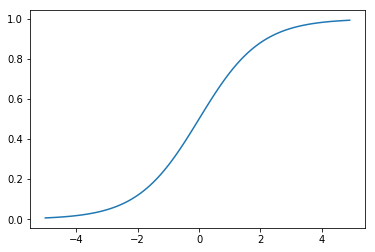

In [4]:
# Logistic Regression
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

def logistic(z):
    return 1. / (1. + nd.exp(-z))

x = nd.arange(-5, 5, 0.1)
y = logistic(x)

plt.plot(x.asnumpy(),y.asnumpy())
plt.show()

In [8]:
# Data!
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html#Data
data_ctx = mx.cpu()
# Change this to `mx.gpu(0) if you would like to train on an NVIDIA GPU
model_ctx = mx.cpu()

with open("../data/a1a.train") as f:
    train_raw = f.read()

with open("../data/a1a.test") as f:
    test_raw = f.read()


In [10]:
# Data prep
def process_data(raw_data):
    train_lines = raw_data.splitlines()
    num_examples = len(train_lines)
    num_features = 123
    X = nd.zeros((num_examples, num_features), ctx=data_ctx)
    Y = nd.zeros((num_examples, 1), ctx=data_ctx)
    for i, line in enumerate(train_lines):
        tokens = line.split()
        label = (int(tokens[0]) + 1) / 2  # Change label from {-1,1} to {0,1}
        Y[i] = label
        for token in tokens[1:]:
            index = int(token[:-2]) - 1
            X[i, index] = 1
    return X, Y

Xtrain, Ytrain = process_data(train_raw)
Xtest, Ytest = process_data(test_raw)

In [12]:
# make sure data has correct shapes
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

# We can also check the fraction of positive examples in our training and test sets. 
# This will give us one nice (necessay but insufficient) sanity check that our training 
# and test data really are drawn from the same distribution.
print(nd.sum(Ytrain)/len(Ytrain))
print(nd.sum(Ytest)/len(Ytest))

(1605, 123)
(1605, 1)
(30956, 123)
(30956, 1)

[ 0.24610592]
<NDArray 1 @cpu(0)>

[ 0.24053495]
<NDArray 1 @cpu(0)>


In [13]:
# instantiate data loader
batch_size = 64

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, Ytrain),
                                      batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, Ytest),
                                      batch_size=batch_size, shuffle=True)

# Define Model
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

# instantiate optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
# loss function (handmade)



In [25]:
# Define Loss
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html#Define-log-loss
# test_count = 0
def log_loss(output, y):
#     global test_count
    yhat = logistic(output)
#     if test_count < 4:
#         print(yhat)
#     test_count = test_count + 1
    return  - nd.nansum(  y * nd.log(yhat) + (1-y) * nd.log(1-yhat))

epochs = 30
loss_sequence = []
num_examples = len(Xtrain)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = log_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)


[[  6.70878112e-01]
 [  6.95341825e-02]
 [  1.74029749e-02]
 [  4.99204665e-01]
 [  1.72974929e-01]
 [  7.82883465e-02]
 [  2.53303975e-01]
 [  8.51903617e-01]
 [  8.41954827e-01]
 [  3.01446784e-02]
 [  5.86411178e-01]
 [  5.58427855e-05]
 [  1.16109207e-01]
 [  2.70107668e-02]
 [  3.07551585e-02]
 [  7.79048540e-03]
 [  6.33894950e-02]
 [  3.80483299e-01]
 [  2.32657775e-01]
 [  8.56002560e-04]
 [  2.30643168e-01]
 [  1.61124587e-01]
 [  9.32790339e-01]
 [  1.25674501e-01]
 [  1.13289364e-01]
 [  7.09290877e-02]
 [  5.45037091e-01]
 [  1.42092723e-03]
 [  6.57098135e-03]
 [  1.77725971e-01]
 [  3.40156466e-01]
 [  4.51648980e-02]
 [  1.82789732e-02]
 [  5.80046475e-01]
 [  3.44432116e-01]
 [  2.86252762e-04]
 [  5.24378120e-05]
 [  4.86805201e-01]
 [  1.72539577e-01]
 [  2.87806600e-01]
 [  6.47506043e-02]
 [  3.45500708e-01]
 [  1.38706744e-01]
 [  1.45637721e-03]
 [  3.73933464e-01]
 [  3.13403904e-01]
 [  4.28726189e-02]
 [  4.43640240e-02]
 [  5.39898910e-02]
 [  7.74472535e-01]

Text(0,0.5,'average loss')

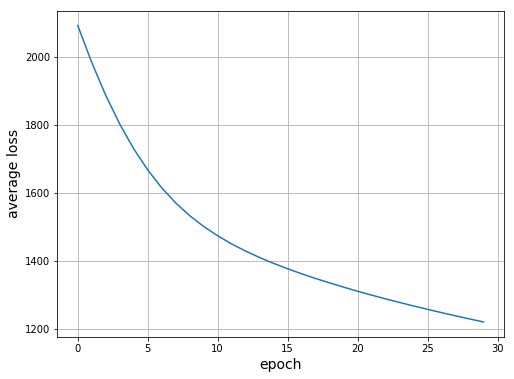

In [15]:
# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [16]:
# calculate accuracy
# http://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html#Calculating-accuracy
num_correct = 0.0
num_total = len(Xtest)
for i, (data, label) in enumerate(test_data):
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    output = net(data)
    prediction = (nd.sign(output) + 1) / 2
    num_correct += nd.sum(prediction == label)
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

Accuracy: 0.735 (22762.0/30956)


In [23]:
a_var = 1

def a_func():
    a_var = a_var + 1
    print(a_var, '[ a_var inside a_func() ]')

print(a_var, '[ a_var outside a_func() ]')
a_func()

1 [ a_var outside a_func() ]


UnboundLocalError: local variable 'a_var' referenced before assignment